In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.0.0


In [4]:
def data_processing(file_name, file_name_D):
    """
    Read the csv files and create game characterstic features and player statistic features
    """
    df = pd.read_csv(file_name)
    df_D = pd.read_csv(file_name_D)
    df.sort_values(by = ['Name', 'Unnamed: 2_level_0 G#']) # for rolling average
    # All box score player stats, except defensive statistics
    stats = ['Passing AY/A', 'Passing Att', 'Passing Cmp', 'Passing Cmp%',
            'Passing Int', 'Passing Rate', 'Passing Sk', 'Passing TD',
            'Passing Y/A', 'Passing Yds', 'Passing Yds.1', 'Rushing Att',
            'Rushing TD', 'Rushing Y/A', 'Rushing Yds','FPoints']
    # Opponent Characteristics
    df, opp_features = get_opp_d(df, df_D)
    # Game Characteristic Indicators, e.g. home/away, opponent, team
#     df, game_features = get_game_char_indicators(df)
    # Player Statistic Features, e.g. Season, last 4 weeks, previous week
    df, player_features = get_player_averages(df, stats)
#     features = game_features + player_features
#     features = player_features
    features = player_features + opp_features
    df = df.fillna(0)
    return df, features


def get_game_char_indicators(df):
    """
    Transform str cols into game categorical variables
    Returns transformed and columns
    """
    df['home'] = 1 * df['Unnamed: 6_level_0 Unnamed: 6_level_1'] == '0'
    oppts = pd.get_dummies(df['Unnamed: 7_level_0 Opp'], prefix='Oppt')
    teams = pd.DataFrame()
    team_list = pd.Series('ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET',\
                           'GB', 'HOU', 'IND', 'JAC', 'KC', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ',\
                           'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEN', 'WAS')
    for team in df['Unnamed: 5_level_0 Tm']:
        temp = (team_list == team)
        teams = teams.append(temp, ignore_index=True)
    teams.index = range(len(df['Unnamed: 5_level_0 Tm']))
    teams.columns = list(team_list)
    df = pd.concat([df, oppts, teams], axis=1)
    return df, ['home'] + list(oppts.columns) + list(team_list)

def get_opp_d(df, df_D):

    d_stats = ['PF', 'Yds','Tot Yds & TO Ply','Tot Yds & TO Y/P','Tot Yds & TO TO','FL','1stD','Passing Cmp','Passing Att',
             'Passing Yds','Passing TD','Passing Int','Passing NY/A','Passing 1stD','Penalties Pen','Penalties Yds',
             'Penalties 1stPy','Sc%','Unnamed: 26_level_0 TO%','EXP']
    df_D['Season']= df_D['Season'].astype(str)
#     for stat in df[d_stats + ['FPoints']]:
#         opp = abbrev_dict[df['Unnamed: 7_level_0 Opp']]
#         df['D_'+stat] = df_D.loc[df_D['Tm'] == opp][stat]
    for stat in d_stats:
#         print(stat)
        df[stat] = df.apply(lambda row: get_team_stat(row,stat,df_D), axis=1)
    return df, d_stats
def get_team_stat(row,stat,df_D):
    abbrev_dict = {'ARI':'Arizona Cardinals', 'ATL':'Atlanta Falcons', 'BAL':'Baltimore Ravens', 'BUF':'Buffalo Bills', 
                          'CAR':'Carolina Panthers', 'CHI':'Chicago Bears', 'CIN':'Cincinnati Bengals', 
                          'CLE':'Cleveland Browns', 'DAL':'Dallas Cowboys', 'DEN':'Denver Broncos', 'DET':'Detroit Lions', 
                          'GB':'Green Bay Packers','GNB':'Green Bay Packers', 'HOU': 'Houston Texans', 'IND':'Indianapolis Colts', 
                          'JAC':'Jacksonville Jaguars', 'JAX':'Jacksonville Jaguars','KAN':'Kansas City Chiefs','KC':'Kansas City Chiefs','LAC':'Los Angeles Chargers',
                          'LAR':'Los Angeles Rams', 'MIA':'Miami Dolphins', 'MIN':'Minnesota Vikings','NE':'New England Patriots','NWE':'New England Patriots',
                          'NO':'New Orleans Saints','NOR':'New Orleans Saints', 'NYG':'New York Giants', 'NYJ':'New York Jets','OAK':'Oakland Raiders', 
                          'PHI':'Philadelphia Eagles', 'PIT':'Pittsburgh Steelers', 'SD':'San Diego Chargers', 'SDG':'San Diego Chargers', 'SEA':'Seattle Seahawks', 
                          'SF':'San Francisco 49ers', 'SFO':'San Francisco 49ers','STL':'St. Louis Rams', 'TB':'Tampa Bay Buccaneers',
                           'TEN':'Tennessee Titans', 'TAM':'Tampa Bay Buccaneers',
                          'WAS':'Washington Redskins'}
#     print(row)
#     print(df_D['Season'])
    df_D.index=df_D['Tm']+df_D['Season']
#     print(df_D)
    opp = abbrev_dict[row['Unnamed: 7_level_0 Opp']]+str(row['Season'])
#     print(type(df_D.loc[df_D['Tm']==opp][stat]))
#     print(opp,stat)
    return df_D.at[opp,stat]

def rolling_average(df, window):
    return df.rolling(min_periods=1, window=window).mean().shift(1)

def get_player_averages(df, stats):
    """
    Estimate player averages for all stats and FanDuel point histories,
    for season-to-date, last 4 weeeks, and previous week
    """
    feature_names = []
    for stat in df[stats + ['FPoints']]:
        df['season_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 16))
        df['recent_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 4))
        df['prev_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 1))
        feature_names = feature_names + [time + "_" + stat for time in ['season', 'recent', 'prev']]
    return df, feature_names


path = "data/"
train, features = data_processing(path + 'QB_all.csv', path + 'teams_all.csv')
# test, features2 = data_processing(path + 'gamelog_QB_2018.csv', path + 'teams_2018.csv')
# if (features != features2):
#     print("Debug error about feature inconsistency")
#     exit()

In [5]:
train

,Unnamed: 0,Def. Snaps Num,Def. Snaps Pct,FPoints,Fumbles FF,Fumbles FR,Fumbles Fmb,Fumbles TD,Fumbles Yds,Kick Returns Rt,...,prev_Rushing TD,season_Rushing Y/A,recent_Rushing Y/A,prev_Rushing Y/A,season_Rushing Yds,recent_Rushing Yds,prev_Rushing Yds,season_FPoints,recent_FPoints,prev_FPoints
0,0,0.0,0,23.52,0.0,0.0,1.0,0.0,-17.0,0.0,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00
1,1,0.0,0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.670000,-0.670000,-0.67,-2.000000,-2.000000,-2.0,23.520000,23.520000,23.52
2,2,0.0,0,20.84,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,4.165000,4.165000,9.00,3.500000,3.500000,9.0,16.530000,16.530000,9.54
3,3,0.0,0,24.42,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.776667,2.776667,0.00,2.333333,2.333333,0.0,17.966667,17.966667,20.84
4,4,0.0,0,11.80,0.0,0.0,3.0,0.0,-17.0,0.0,...,0.0,1.832500,1.832500,-1.00,1.500000,1.500000,-1.0,19.580000,19.580000,24.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,5876,0.0,0%,0.00,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,4.417273,4.707500,6.50,15.818182,12.750000,13.0,2.673333,1.375000,1.30
5877,5877,0.0,0%,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.049167,3.457500,0.00,14.500000,10.250000,0.0,2.673333,1.500000,0.00
5878,5878,0.0,0%,1.70,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.276154,0.457500,-6.00,12.923077,2.750000,-6.0,2.673333,1.050000,0.00
5879,5879,0.0,0%,-2.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.256429,4.375000,17.00,13.214286,6.000000,17.0,2.576000,1.500000,1.70


In [7]:
features.append('FPoints')
# features.remove('home')
# features.remove('FPoints')
print(features)
dataset = train[features]
# dataset
train_dataset = dataset.sample(frac=0.8,random_state=0)
# print(train_dataset)
test_dataset = dataset.drop(train_dataset.index)
train_stats = train_dataset.describe(include='all')
train_stats.pop('FPoints')
train_stats = train_stats.transpose()
train_stats

['season_Passing AY/A', 'recent_Passing AY/A', 'prev_Passing AY/A', 'season_Passing Att', 'recent_Passing Att', 'prev_Passing Att', 'season_Passing Cmp', 'recent_Passing Cmp', 'prev_Passing Cmp', 'season_Passing Cmp%', 'recent_Passing Cmp%', 'prev_Passing Cmp%', 'season_Passing Int', 'recent_Passing Int', 'prev_Passing Int', 'season_Passing Rate', 'recent_Passing Rate', 'prev_Passing Rate', 'season_Passing Sk', 'recent_Passing Sk', 'prev_Passing Sk', 'season_Passing TD', 'recent_Passing TD', 'prev_Passing TD', 'season_Passing Y/A', 'recent_Passing Y/A', 'prev_Passing Y/A', 'season_Passing Yds', 'recent_Passing Yds', 'prev_Passing Yds', 'season_Passing Yds.1', 'recent_Passing Yds.1', 'prev_Passing Yds.1', 'season_Rushing Att', 'recent_Rushing Att', 'prev_Rushing Att', 'season_Rushing TD', 'recent_Rushing TD', 'prev_Rushing TD', 'season_Rushing Y/A', 'recent_Rushing Y/A', 'prev_Rushing Y/A', 'season_Rushing Yds', 'recent_Rushing Yds', 'prev_Rushing Yds', 'season_FPoints', 'recent_FPoints

,count,mean,std,min,25%,50%,75%,max
season_Passing AY/A,4705.0,6.634659,2.130338,-21.75,5.86375,6.908125,7.8000,32.50
recent_Passing AY/A,4705.0,6.660933,2.488631,-21.75,5.57250,6.885000,8.0950,32.50
prev_Passing AY/A,4705.0,6.667248,3.974520,-45.00,4.74000,6.740000,8.7600,44.00
season_Passing Att,4705.0,535.959618,86.474969,0.00,533.25000,550.812500,564.5625,670.00
recent_Passing Att,4705.0,537.018154,87.804962,0.00,532.25000,550.250000,567.0000,670.00
...,...,...,...,...,...,...,...,...
Penalties Yds,4705.0,862.175983,132.225328,498.00,769.00000,863.000000,948.0000,1208.00
Penalties 1stPy,4705.0,27.937513,7.902489,10.00,23.00000,28.000000,33.0000,58.00
Sc%,4705.0,33.928948,4.976659,20.30,30.40000,33.700000,37.8000,46.40
Unnamed: 26_level_0 TO%,4705.0,12.367120,3.048711,3.90,10.20000,12.400000,14.3000,21.00


In [8]:
train_labels = train_dataset.pop('FPoints')
test_labels = test_dataset.pop('FPoints')
train_labels

840     19.28
3161     0.00
3065    12.24
3067    16.92
3924    15.26
        ...  
3436    11.50
4256     0.00
5692    17.16
5612     7.34
5308    13.50
Name: FPoints, Length: 4705, dtype: float64

In [9]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

840     19.28
3161     0.00
3065    12.24
3067    16.92
3924    15.26
        ...  
3436    11.50
4256     0.00
5692    17.16
5612     7.34
5308    13.50
Name: FPoints, Length: 4705, dtype: float64

In [10]:
def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])


#     model=keras.Sequential()
# #     model.add(layers.Dense(64,input_shape=[len(train_dataset.keys())]))
#     model.add(layers.Dense(64,input_shape=[len(train_dataset.keys())]))
# #     model.add(layers.LeakyReLU(alpha=0.6))
# #     model.add(layers.Dense(64))
# #     model.add(layers.LeakyReLU(alpha=0.6))
#     model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model
model = build_model()

In [11]:
example_batch = normed_train_data[:10]
example_batch

,season_Passing AY/A,recent_Passing AY/A,prev_Passing AY/A,season_Passing Att,recent_Passing Att,prev_Passing Att,season_Passing Cmp,recent_Passing Cmp,prev_Passing Cmp,season_Passing Cmp%,...,Passing TD,Passing Int,Passing NY/A,Passing 1stD,Penalties Pen,Penalties Yds,Penalties 1stPy,Sc%,Unnamed: 26_level_0 TO%,EXP
840,-0.430523,-0.379097,-0.879917,0.353170,0.335765,-0.068535,0.636303,0.594727,0.140127,0.514813,...,0.894070,3.235147,-1.133092,-1.056429,0.366029,0.391937,1.020247,-1.733884,2.831649,1.354886
3161,-0.325199,-0.215352,-0.935270,0.145740,0.216182,0.016546,0.015705,-0.148015,-0.005356,-0.117223,...,0.179937,0.294875,-0.136762,-0.660038,1.788502,2.524660,0.134450,-0.508162,-0.678031,-0.178317
3065,0.690192,0.580266,1.178193,0.301132,0.284515,0.112262,0.353383,0.318979,0.511916,0.760360,...,0.179937,1.344973,-0.136762,-0.015902,0.740364,-0.076959,-0.245178,-1.291820,1.093209,-0.128527
3067,-0.354244,-0.169142,-1.705174,0.372444,0.495209,0.335599,0.242345,0.252265,-0.053851,0.350138,...,0.179937,0.924934,0.527459,2.461544,0.291162,-0.054271,0.134450,-0.246942,0.962007,-0.792436
3924,0.478077,0.433599,0.579379,0.410268,0.250349,-0.366318,0.490280,0.403482,-0.215498,0.228975,...,-0.891262,-1.385280,0.859569,-0.858234,0.815231,0.286057,0.514077,0.556810,-2.219666,-0.977755
5176,-0.686351,-0.047589,0.219587,0.061178,-0.185276,-0.408859,0.173136,0.020992,-0.571123,0.366937,...,0.715537,-1.595300,0.527459,-0.015902,-0.083173,0.331434,0.387534,0.456341,-1.793256,-0.261051
842,-0.232980,-0.529782,-0.009372,0.193201,0.105140,-0.291872,0.357947,0.252265,0.204786,0.300520,...,0.537003,-0.335183,0.527459,0.727332,0.665497,0.823019,-0.877890,-0.046004,-0.546828,-0.042574
1789,0.147437,0.247754,-0.150269,0.176096,0.056738,0.675923,0.023691,-0.312575,-0.134674,0.032703,...,0.358470,1.765011,1.357735,2.758837,0.964965,0.338997,-0.498262,-0.267036,1.552420,0.498575
3768,0.598950,0.753052,0.274939,0.237530,0.321529,0.027181,0.330567,0.332321,0.576576,0.362835,...,-0.534195,-0.335183,0.195349,0.132745,0.515763,0.981839,0.260992,-0.427787,-0.087617,-0.030878
2030,-0.595520,-0.734714,-1.003202,0.018969,-0.085623,0.133532,0.018443,0.007649,0.414928,-0.812004,...,-0.534195,-0.545202,0.029293,-1.155527,0.665497,0.671762,-0.371720,0.396059,-1.137241,-0.279079


In [12]:
example_result = model.predict(example_batch)
example_result

array([[ 2.0119524 ],
       [ 1.575748  ],
       [ 0.831795  ],
       [ 1.7082646 ],
       [-0.00834585],
       [-0.45620877],
       [ 0.80366135],
       [ 1.1245098 ],
       [ 0.72472703],
       [ 0.5329708 ]], dtype=float32)

In [13]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

print(normed_train_data.shape, train_labels.shape)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

(4705, 71) (4705,)

....................................................................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,43.099246,5.226776,43.099247,57.105837,6.015333,57.105839,95
96,43.095395,5.240256,43.095402,56.841496,5.995218,56.841496,96
97,42.912726,5.207525,42.912731,57.288222,6.024733,57.288227,97
98,42.949005,5.214087,42.949013,57.526310,6.045176,57.526318,98
99,42.747506,5.208061,42.747505,57.763065,6.034536,57.763065,99


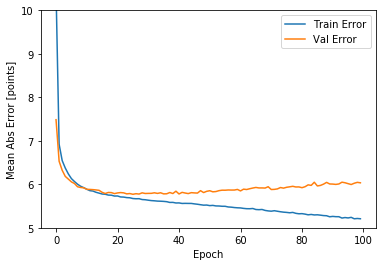

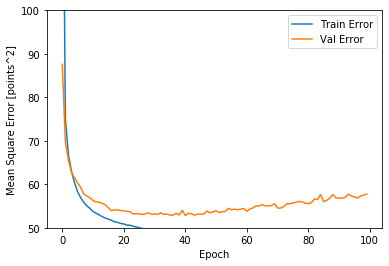

In [15]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [points]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [points^2]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([50,100])
  plt.legend()
  plt.show()
plot_history(history)


.....................................

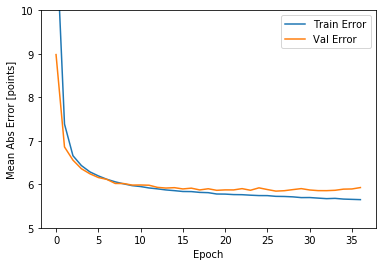

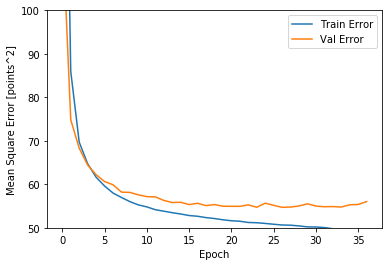

In [16]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} points".format(mae))

1176/1176 - 0s - loss: 59.8454 - mae: 6.1389 - mse: 59.8454
Testing set Mean Abs Error:  6.14 points


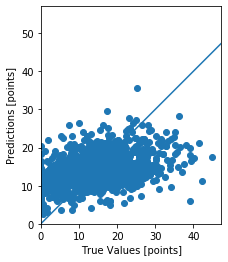

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [points]')
plt.ylabel('Predictions [points]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

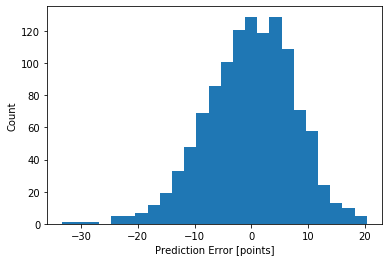

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [points]")
_ = plt.ylabel("Count")